In [1]:
# Import libraries
from google.colab import drive
import os
import shutil
import zipfile
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
import numpy as np
import keras
from keras import layers
from keras.applications import EfficientNetB0

In [2]:
# Mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import the folder which contains the data
path = '/content/drive/My Drive/Colab Notebooks'
os.chdir(path)

In [4]:
# Run this to delete the 'images folder' (if you want to re-load images after)
folder_to_delete = '/content/images'
try:
    # Delete the folder and its contents
    shutil.rmtree(folder_to_delete)
    print(f"Successfully deleted the folder: {folder_to_delete}")
except Exception as e:
    print(f"Error deleting the folder: {e}")

Error deleting the folder: [Errno 2] No such file or directory: '/content/images'


In [5]:
# Unzip the images file to Google colab's virtual disk
with zipfile.ZipFile('images-small.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [6]:
# See how many images we have
len(os.listdir('/content/images'))

128575

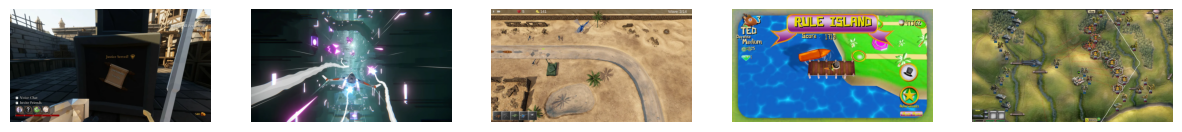

In [7]:
# Display the first few images

# Define the directory containing the images
image_dir = '/content/images/'

# Get a list of image filenames
image_files = os.listdir(image_dir)

# Display the first few images
num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i, filename in enumerate(image_files[:num_images_to_display]):
    # Load the image
    img_path = os.path.join(image_dir, filename)
    img = plt.imread(img_path)

    # Display the image
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()


In [8]:
# loading the json dataset and looking at the first few elements
file_path = '/content/dataset_webp.json'
with open(file_path, 'r') as file:
  json_data = json.load(file)

# show the first 3 objects
json_data[:3]


[{'appid': '2805630',
  'release': '2024-02-24',
  'title': 'BotMobile',
  'price': 1173,
  'sentiment': 'Positive',
  'reviews': '10',
  'percentage': '100',
  'tags': ['Action',
   'Action-Adventure',
   'Adventure',
   'Casual',
   'Choose Your Own Adventure',
   'Combat Racing',
   'Cute',
   'Driving',
   'Minimalist',
   'Physics',
   'Racing',
   'Rhythm',
   'Simulation',
   'Singleplayer',
   'Sports',
   'Strategy',
   'Third Person'],
  'screenshots': ['2805630_ss_02b69bffacf19807fb6202fb8167fad7e08eae77.1920x1080.webp',
   '2805630_ss_67edf620e44492c0110912c2a6672113011aa94c.1920x1080.webp',
   '2805630_ss_790259f92a9ba5f506a00eafc9efa4fb2dc9686d.1920x1080.webp',
   '2805630_ss_a25f2dcb34e2688eaa6c9a971c38a03dbdab18fb.1920x1080.webp',
   '2805630_ss_b8fb2eff1ddc2816f0ec744d467ab3dfe9d584e1.1920x1080.webp',
   '2805630_ss_c1a17e1b1ca267e911de2948f426b34b07cca172.1920x1080.webp',
   '2805630_ss_c96c5067160ab0a5eeb71142478872313ee4d234.1920x1080.webp',
   '2805630_ss_fc7976bb6

In [9]:
# Get to know our data - what sentiments do we have, how many objects to they have and how many screenshots
def count_sentiments(json_data):
    # Initialize a dictionary to hold sentiment counts and screenshot counts
    sentiment_data = defaultdict(lambda: {'count': 0, 'screenshots_count': 0})

    # Iterate over each JSON object and count the sentiments and screenshots
    for obj in json_data:
        sentiment = obj.get('sentiment')
        sentiment_data[sentiment]['count'] += 1

        # Count the screenshots if the 'screenshots' key exists
        screenshots = obj.get('screenshots', [])
        sentiment_data[sentiment]['screenshots_count'] += len(screenshots)

    return dict(sentiment_data)

# Count number of objects and nr. of screenshots in the json file grouped by sentiment (for whole json and first 1000 objects)
print('----- Whole json -----')
for sentiment, data in count_sentiments(json_data).items():
    print(f"Sentiment: {sentiment}, Count: {data['count']}, Screenshots Count: {data['screenshots_count']}")
print('----- First 1000 elements of json -----')
for sentiment, data in count_sentiments(json_data[:1000]).items():
    print(f"Sentiment: {sentiment}, Count: {data['count']}, Screenshots Count: {data['screenshots_count']}")

----- Whole json -----
Sentiment: Positive, Count: 2561, Screenshots Count: 22429
Sentiment: None, Count: 7783, Screenshots Count: 62849
Sentiment: Mixed, Count: 1144, Screenshots Count: 11228
Sentiment: Very Positive, Count: 1844, Screenshots Count: 18877
Sentiment: Mostly Positive, Count: 1031, Screenshots Count: 10197
Sentiment: Overwhelmingly Positive, Count: 172, Screenshots Count: 1624
Sentiment: Mostly Negative, Count: 128, Screenshots Count: 1164
Sentiment: Negative, Count: 21, Screenshots Count: 182
Sentiment: Very Negative, Count: 2, Screenshots Count: 15
Sentiment: Overwhelmingly Negative, Count: 1, Screenshots Count: 12
----- First 1000 elements of json -----
Sentiment: Positive, Count: 162, Screenshots Count: 1342
Sentiment: None, Count: 614, Screenshots Count: 4965
Sentiment: Mixed, Count: 53, Screenshots Count: 516
Sentiment: Very Positive, Count: 98, Screenshots Count: 953
Sentiment: Mostly Positive, Count: 54, Screenshots Count: 539
Sentiment: Overwhelmingly Positive, 

In [10]:
# Overwhelmingly Negative and Very Negative sentiments only have a few games/screenshots --> change them to "Negative"
for game in json_data:
    if game.get('sentiment') in ["Overwhelmingly Negative", "Very Negative"]:
        game['sentiment'] = "Negative"

In [11]:
# Move images into 'train' and 'val' folders with subfolders based on sentiment. Images are converted to JPG
# It is made sure train-val split happens at the level of games (json objects) and not on the level of screenshots.

# Reduce the JSON size by taking only the first 1000 objects in it to speed up training time - for experimenting
# json_data = json_data[:1000]

# Function to convert .webp images to .jpg
def convert_webp_to_jpg(image_path):
    with Image.open(image_path) as img:
        rgb_img = img.convert('RGB')  # Ensure image is in RGB color space
        jpg_path = image_path.rsplit('.', 1)[0] + '.jpg'
        rgb_img.save(jpg_path, 'JPEG')
    os.remove(image_path)  # Remove the original .webp file
    return jpg_path

# Initialize counters
total_image_paths = 0
num_images_moved = 0
num_images_not_found = 0
num_records_no_sentiment = 0
num_screenshots_no_sentiment = 0

# Collect all image paths in the JSON
json_image_paths = set()
for obj in json_data:
    screenshots = obj.get('screenshots', [])
    for screenshot in screenshots:
        json_image_paths.add(screenshot)
        total_image_paths += 1

print("Total number of image paths in JSON:", total_image_paths)

# Remove images not in the JSON subset - happens if the code is run on a subset of the json file (e.g. first 1000 objects)
all_images_in_dir = {file for file in os.listdir(image_dir) if file.endswith('.webp')}
images_to_delete = all_images_in_dir - json_image_paths

for image_to_delete in images_to_delete:
    os.remove(os.path.join(image_dir, image_to_delete))

print(f"Deleted {len(images_to_delete)} images not in the JSON subset.")

# Separate games with and without sentiment
games_with_sentiment = [obj for obj in json_data if obj.get('sentiment') is not None]
games_without_sentiment = [obj for obj in json_data if obj.get('sentiment') is None]

# Delete games without sentiment
for obj in games_without_sentiment:
    screenshots = obj.get('screenshots', [])
    num_screenshots_no_sentiment += len(screenshots)
    for screenshot in screenshots:
        src_path = os.path.join(image_dir, screenshot)
        if os.path.exists(src_path):
            os.remove(src_path)
        else:
            num_images_not_found += 1
            print(f"File '{screenshot}' not found. Skipping...")

num_records_no_sentiment = len(games_without_sentiment)
print("Number of records with no sentiment:", num_records_no_sentiment)
print("Number of screenshots with no sentiment:", num_screenshots_no_sentiment)

# Split games into training and validation sets
train_games, val_games = train_test_split(games_with_sentiment, test_size=0.2, random_state=42)

# Helper function to move images to the appropriate directory
def move_images(game_objs, dataset_type):
    global num_images_moved, num_images_not_found

    for obj in game_objs:
        sentiment = obj.get('sentiment')
        screenshots = obj.get('screenshots', [])

        # Create a folder for the sentiment and dataset type if it doesn't exist
        dataset_sentiment_dir = os.path.join(image_dir, dataset_type, sentiment)
        os.makedirs(dataset_sentiment_dir, exist_ok=True)

        # Move the corresponding images to the folder
        for screenshot in screenshots:
            src_path = os.path.join(image_dir, screenshot)
            if os.path.exists(src_path):
                # Convert to JPG and move
                jpg_path = convert_webp_to_jpg(src_path)
                dst_path = os.path.join(dataset_sentiment_dir, os.path.basename(jpg_path))
                shutil.move(jpg_path, dst_path)
                num_images_moved += 1
            else:
                num_images_not_found += 1
                print(f"File '{screenshot}' not found. Skipping...")

# Move images for training and validation sets
move_images(train_games, 'train')
move_images(val_games, 'val')

# Print summary
print("Number of images moved:", num_images_moved)
print("Number of images not found:", num_images_not_found)

# Delete any remaining .webp images in the main directory that were not referenced
remaining_images_in_dir = [file for file in os.listdir(image_dir) if file.endswith('.webp')]
for image_to_delete in remaining_images_in_dir:
    os.remove(os.path.join(image_dir, image_to_delete))

Total number of image paths in JSON: 128577
Deleted 0 images not in the JSON subset.
Number of records with no sentiment: 7783
Number of screenshots with no sentiment: 62849
File '1029210_ss_7096afc94036153001b266a75253fb6abdd03c54.1920x1080.webp' not found. Skipping...
File '1029210_ss_ddf975e414f08a0bb419818d2cd94be4ebff6db9.1920x1080.webp' not found. Skipping...
Number of images moved: 65726
Number of images not found: 2


In [12]:
# Create the datasets without further splitting
batch_size = 64
img_height = 224
img_width = 224

train_ds = image_dataset_from_directory(
    directory=os.path.join(image_dir, 'train'),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical')

val_ds = image_dataset_from_directory(
    directory=os.path.join(image_dir, 'val'),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical')

# Print summary of datasets
class_names = train_ds.class_names
print("Class names:", class_names)
print("Number of batches in train dataset:", tf.data.experimental.cardinality(train_ds).numpy())
print("Number of batches in validation dataset:", tf.data.experimental.cardinality(val_ds).numpy())

Found 52378 files belonging to 7 classes.
Found 13348 files belonging to 7 classes.
Class names: ['Mixed', 'Mostly Negative', 'Mostly Positive', 'Negative', 'Overwhelmingly Positive', 'Positive', 'Very Positive']
Number of batches in train dataset: 819
Number of batches in validation dataset: 209


In [13]:
# Get some summary statistics about the files in the folders
def count_screenshots_in_dir(directory):
    total_files = 0
    subfolder_files = {}

    for root, dirs, files in os.walk(directory):
        num_files = len([file for file in files if file.endswith('.jpg')])
        if root == directory:
            total_files += num_files
        else:
            subfolder = os.path.basename(root)
            subfolder_files[subfolder] = num_files
            total_files += num_files

    return total_files, subfolder_files

# Directory paths
train_dir = os.path.join(image_dir, 'train')
val_dir = os.path.join(image_dir, 'val')

# Count screenshots in train directory and its subfolders
total_train_files, train_subfolders = count_screenshots_in_dir(train_dir)
print("Total screenshots in 'train' folder:", total_train_files)
print("Screenshots in subfolders of 'train':", train_subfolders)

# Count screenshots in val directory and its subfolders
total_val_files, val_subfolders = count_screenshots_in_dir(val_dir)
print("Total screenshots in 'val' folder:", total_val_files)
print("Screenshots in subfolders of 'val':", val_subfolders)


Total screenshots in 'train' folder: 52378
Screenshots in subfolders of 'train': {'Very Positive': 15131, 'Mostly Negative': 936, 'Mostly Positive': 8006, 'Mixed': 9139, 'Overwhelmingly Positive': 1223, 'Negative': 147, 'Positive': 17796}
Total screenshots in 'val' folder: 13348
Screenshots in subfolders of 'val': {'Very Positive': 3744, 'Mostly Negative': 228, 'Mostly Positive': 2191, 'Mixed': 2089, 'Overwhelmingly Positive': 401, 'Negative': 62, 'Positive': 4633}


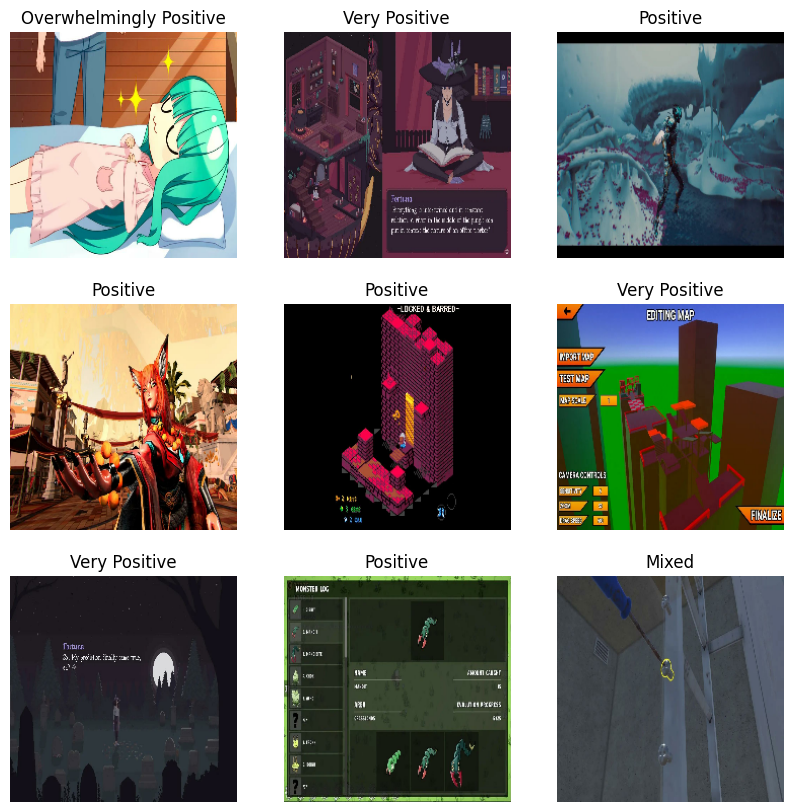

In [14]:
# We can look at a few images and their sentiment (labels) in the training data
def visualize_images(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")

visualize_images(train_ds, class_names)


Data augmentation

In [15]:
img_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.2)
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

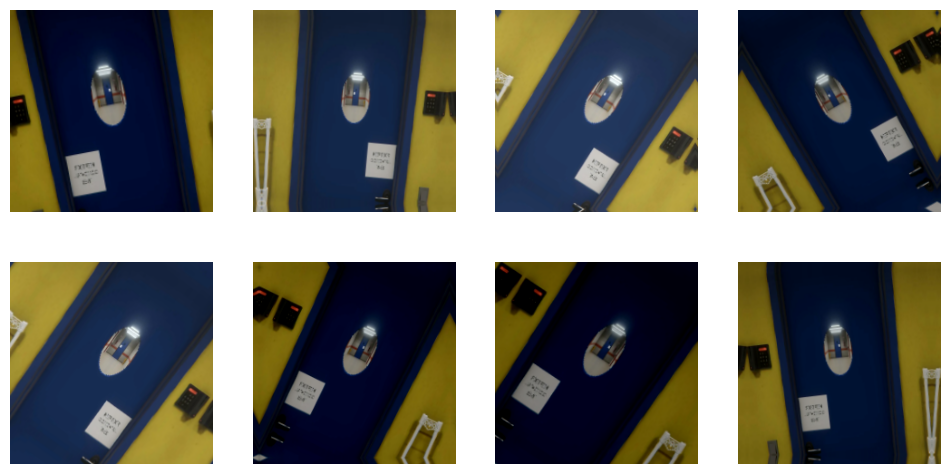

In [16]:
plt.figure(figsize=(12, 6))
for images, _ in train_ds.take(1):
    for i in range(8):
        augmented_images = img_augmentation(images)
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

Prepare inputs

In [17]:
# Get number of classes (even though we know it)
print(class_names)    # This was "calculated" already previously
num_classes = len(class_names)
print(num_classes)

['Mixed', 'Mostly Negative', 'Mostly Positive', 'Negative', 'Overwhelmingly Positive', 'Positive', 'Very Positive']
7


In [18]:
# Apply `img_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# change dataset names to train_ds, val_ds in final code

Model

In [19]:
def build_model(num_classes):
    inputs = layers.Input(shape=(img_height, img_width, 3))
    model = EfficientNetB0(include_top=False,
                           input_tensor=inputs
                           weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [20]:
model = build_model(num_classes=num_classes)

16705208/16705208 [==============================] - 0s 0us/step


In [21]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][

In [22]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
epochs = 10
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
plot_hist(hist)

Epoch 1/10
819/819 [==============================] - 787s 939ms/step - loss: 1.8711 - accuracy: 0.3292 - val_loss: 1.5342 - val_accuracy: 0.3374
Epoch 2/10
819/819 [==============================] - 773s 941ms/step - loss: 1.4751 - accuracy: 0.3618 - val_loss: 1.5074 - val_accuracy: 0.3471
Epoch 3/10
819/819 [==============================] - 749s 909ms/step - loss: 1.4764 - accuracy: 0.3607 - val_loss: 1.5069 - val_accuracy: 0.3613
Epoch 4/10
157/819 [====>.........................] - ETA: 9:31 - loss: 1.4908 - accuracy: 0.3619

Epoch 5/10
43/43 [==============================] - 369s 8s/step - loss: 1.2324 - accuracy: 0.5791 - val_loss: 2.3397 - val_accuracy: 0.3567
Epoch 6/10
43/43 [==============================] - 363s 8s/step - loss: 1.1642 - accuracy: 0.5813 - val_loss: 2.4096 - val_accuracy: 0.3518
Epoch 7/10
43/43 [==============================] - 347s 8s/step - loss: 1.1560 - accuracy: 0.6090 - val_loss: 2.4690 - val_accuracy: 0.3518
Epoch 8/10
43/43 [==============================] - 356s 8s/step - loss: 1.1312 - accuracy: 0.6101 - val_loss: 2.5169 - val_accuracy: 0.3530
Epoch 9/10
43/43 [==============================] - 383s 9s/step - loss: 1.1280 - accuracy: 0.5972 - val_loss: 2.5487 - val_accuracy: 0.3518
Epoch 10/10
43/43 [==============================] - 396s 9s/step - loss: 1.1291 - accuracy: 0.6097 - val_loss: 2.5737 - val_accuracy: 0.3493


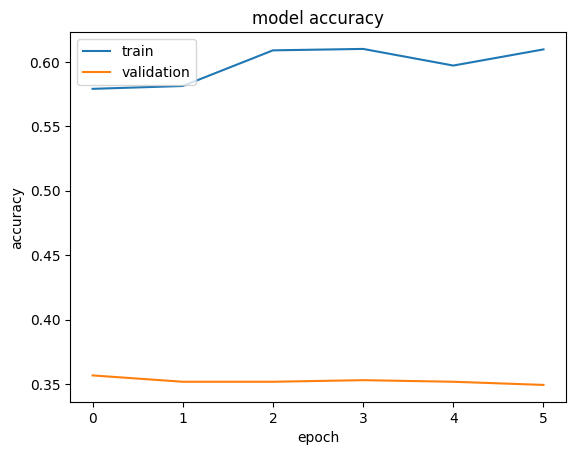

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-8:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

# epochs = 5
fine_tune_epochs = 5
total_epochs = epochs + fine_tune_epochs
hist = model.fit(train_ds, epochs=total_epochs, initial_epoch=hist.epoch[-1], validation_data=val_ds)
#hist = model.fit(train_ds_prefetched, epochs=epochs, validation_data=val_ds_prefetched)
plot_hist(hist)

In [ ]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_12 (Rescaling)    (None, 224, 224, 3)          0         ['input_7[0][0]']             
                                                                                                  
 normalization_6 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_12[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_13 (Rescaling)    (None, 224, 224, 3)          0         ['normalization_6[0

2/2 [==============================] - 8s 3s/step


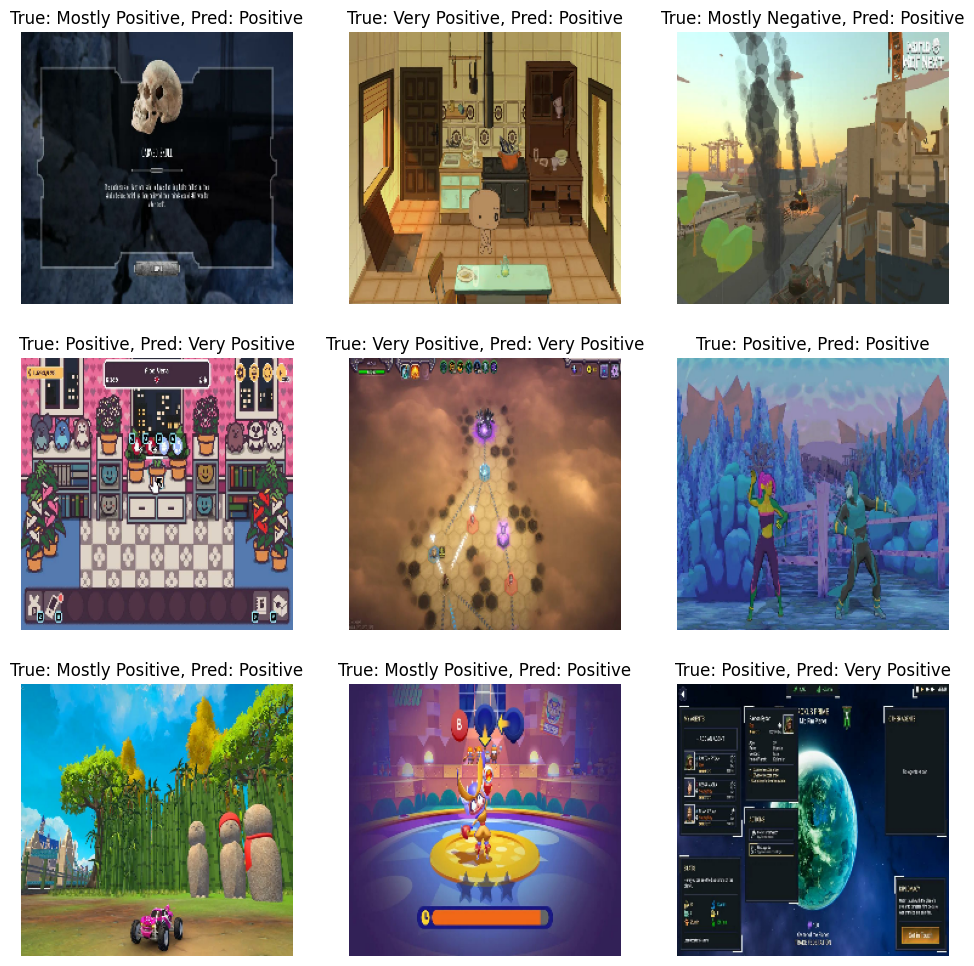

In [ ]:
# Function to plot images with their predictions and true labels
def plot_predictions(images, true_labels, predictions, class_names):
    plt.figure(figsize=(12, 12))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        true_label = class_names[np.argmax(true_labels[i])]
        predicted_label = class_names[np.argmax(predictions[i])]
        plt.title(f"True: {true_label}, Pred: {predicted_label}")
        plt.axis("off")
    plt.show()

# Get a batch of images and labels from the validation dataset
for images, labels in val_ds.take(1):
    # Make predictions
    predictions = model.predict(images)
    # Plot the results
    plot_predictions(images.numpy(), labels.numpy(), predictions, class_names)

2/2 [==============================] - 5s 782ms/step


<Figure size 1000x1000 with 0 Axes>

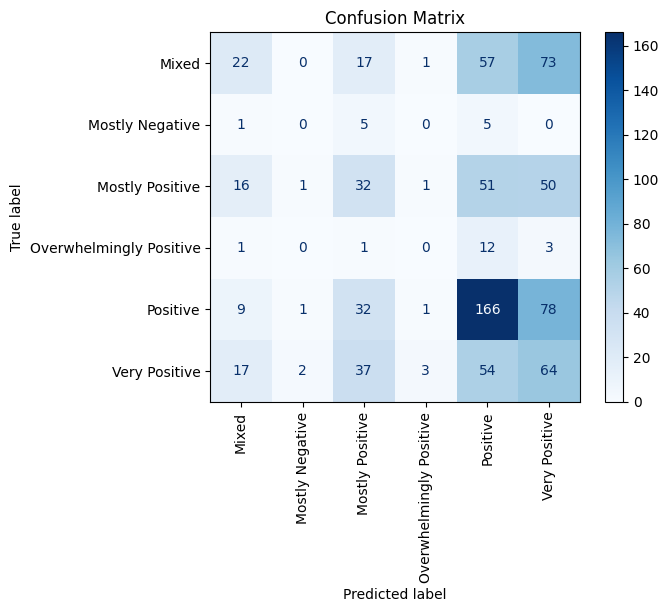

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to get all predictions and true labels from the validation dataset
def get_predictions_and_labels(dataset):
    all_predictions = []
    all_labels = []
    for images, labels in dataset:
        predictions = model.predict(images)
        all_predictions.extend(np.argmax(predictions, axis=1))
        all_labels.extend(np.argmax(labels.numpy(), axis=1))
    return np.array(all_predictions), np.array(all_labels)

# Get predictions and labels from the validation dataset
val_predictions, val_labels = get_predictions_and_labels(val_ds)

# Compute the confusion matrix
cm = confusion_matrix(val_labels, val_predictions)

# Plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)


In [ ]:
model.save('/content/model.keras')

In [ ]:
model = tf.keras.models.load_model('/content/model.keras')